# Create Conference Consultant Sayuri

## Steps

*Make Training Data*

* 会議中の画像の収集
* 画像のデータ化
* ラベルの付与

*Make Model*

* モデルに利用する特徴量の選択
* 学習
* 予測結果の可視化

*Save the Model*

* モデルの保存


In [3]:
# enable showing matplotlib image inline
%matplotlib inline

# autoreload module
%load_ext autoreload
%autoreload 2

# load local package
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "../../../"))  # load project root

## Make Training Data

会議の画像をGoogle等から収集し、`images`フォルダに格納します。なお、画像の拡張子は`PNG`に統一しています。
収集した画像をRekognitionを利用し、特徴量に変換します。この役割を担うのが`make_training_data.py`です。
変換されたデータは、`training_data.csv`として保存されます。

* images_to_data: imagesフォルダ内の画像を特徴量に変換し、`training_data.csv`を作成します。
* append_image: 画像へのパスを引数に渡すことで、その画像のデータを`training_data.csv`に追記します。

ファイルが作成されたら、良い会議なのか悪い会議なのか、ラベル付を行います(良い:1、悪い:0)。ラベルは、ファイルの一番左端に設定します。
このファイルを、`training_data_with_label.csv`として保存してください。


## Make Model

`training_data_with_label.csv`が作成できたら、モデルを作成していきます。当然データの中には複数の特徴量があるため、ここから有用な特徴量を見つけ出し、それをモデルに使用していきます。

まずは、データをロードします。併せて正規化も行っておきます。

In [4]:
from sklearn import preprocessing
import make_model as maker
dataset = maker.load_data()

header = dataset["header"][1:]  # exclude label column
y = dataset["y"]
X = dataset["X"]

scaler = preprocessing.StandardScaler().fit(X)  # regularization
X_R = scaler.transform(X)

print(y.shape)
print(X_R.shape)
print(header)

(50,)
(50, 21)
['pose>pitch min', 'pose>pitch max', 'pose>pitch avg', 'pose>yaw min', 'pose>yaw max', 'pose>yaw avg', 'emotion>sad min', 'emotion>sad max', 'emotion>sad avg', 'smile min', 'smile max', 'smile avg', 'eye_closed min', 'eye_closed max', 'eye_closed avg', 'mouth_open_wide min', 'mouth_open_wide max', 'mouth_open_wide avg', 'sex min', 'sex max', 'sex avg']


会議を分類するモデルにはSVMを使用します。これで、有効な特徴量を探していきます。

In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

get_headers = lambda s: [i_h[1] for i_h in enumerate(header) if s[i_h[0]]]

selector = SelectKBest(f_classif, k=10).fit(X_R, y)

selected = selector.get_support()
kbests = sorted(zip(get_headers(selected), selector.scores_[selected]), key=lambda h_s: h_s[1], reverse=True)
print(kbests)


[('smile avg', 36.027328346678679), ('smile max', 29.165915277225835), ('smile min', 7.5066262394935501), ('emotion>sad min', 6.503727553318039), ('sex max', 5.9620267714449353), ('pose>yaw min', 5.3249580323512582), ('mouth_open_wide avg', 5.0149185119613007), ('eye_closed max', 4.6827070966900699), ('pose>yaw max', 4.6103761988427729), ('pose>pitch min', 4.4763712331461303)]


ここからいくつか特徴量を選択し、モデルを作成します。今回はデータが少ないこともあり、なるべくシンプルなモデルとし特徴量を2つに絞りたいと思います。smile系の特徴量は1つに限定しました。あと一つですが、以下検討の結果pose>pitch minを使用することにしました。

* emotionは検出が安定しない
* sexは男性/女性がいるかいないかだけで決定するのはちょっとおかしいので、除外
* mouth_open/eye_close はその瞬間かどうかで左右されるので除外
* pose系が残るが、この中で最も精度がよかったpose>pitch minを特徴量として採用する

選択した特徴量を元にモデルを作成し、学習させます。モデルは今回SVMを使用しますが、そのパラメーターについてはGrid Searchで最適化します。

モデルが作成できたら、`model/conf_predict.pkl`に保存します。

['pose>pitch min', 'smile avg']
0.925 (+/-0.030) for {'C': 1, 'kernel': 'linear'}
0.899 (+/-0.047) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.001}
0.883 (+/-0.061) for {'C': 10, 'kernel': 'linear'}
0.861 (+/-0.063) for {'C': 100, 'kernel': 'linear'}
0.724 (+/-0.003) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.001}
0.724 (+/-0.003) for {'C': 1, 'kernel': 'rbf', 'gamma': 0.0001}
0.724 (+/-0.003) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.001}
0.724 (+/-0.003) for {'C': 10, 'kernel': 'rbf', 'gamma': 0.0001}
0.724 (+/-0.003) for {'C': 100, 'kernel': 'rbf', 'gamma': 0.0001}
             precision    recall  f1-score   support

       good       0.71      0.83      0.77         6
        bad       0.83      0.71      0.77         7

avg / total       0.78      0.77      0.77        13



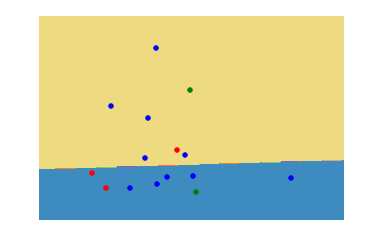

Pipeline(steps=[('scaling', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])


In [13]:
import make_model as maker

header_index = lambda hs: [i_h[0] for i_h in enumerate(header) if i_h[1] in hs]
columns = header_index(["smile avg", "pose>pitch min"])

print([header[c] for c in columns])

model = maker.make_model(y, X, columns, save_model=True)
print(model)
